In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as sm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, RANSACRegressor, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR, OneClassSVM
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from mlxtend.evaluate import bias_variance_decomp

In [3]:
%run functions.ipynb

In [4]:
plt.style.use('seaborn')

# ПРОЕКТ ЗА СЪЗДАВАНЕ НА МОДЕЛИ ЗА ПРЕДСКАЗВАНЕ НА ЦЕНИ НА ЖИЛИЩА

Оценката на цените на жилищата е важно финансово решение за всички участници на пазара на жилища - предприемачи, брокери, оценители, финансови институции и потенциални купувачи. Независимо от ролята на всеки един в процесите, които протичат, всеки един субект се интересува от потенциалната печалба, от пазарната стойност на обекта, който придобива или печалбата, която може да реализира.<br> 
По дефиниция,  в ЕВРОПЕЙСКИТЕ СТАНДАРТИ ЗА ОЦЕНЯВАНЕ (EСО) - 2020 г., определението за „Пазарна стойност” е: „Оценената сума, срещу която даден актив или пасив може да смени собственика си към датата на оценката чрез сделка между независими един от друг, желаещ купувач и желаещ продавач, след подходящ маркетинг, при което всяка от страните е действала информирано, благоразумно и без принуда”.<br>
В този проект ще разгледаме възможни алгоритми за машинно обучение, с цел да бъде разработена система за прогнозиране на цените на жилищата.<br>
Изследването се състои от четири етапа, а именно:
* четене на предварително събрани данни, обработка, анализ и трансформация във формат, подходящ да бъдат приложени
* разработка на модели 
* валидиране и тестване на моделите
* сравнение и избор на най-успешния модел

За целите на настоящия проект се използват данни от ..... <br> 

ХИПОТЕЗА<br>
Дългогодишния ми опит в оценяването на недвижими имоти, показва, че стойността, на която се извършват сделките, често е свързано със субективни фактори, както и явления на пазара, които могат да останат скрити. Стартираме проекта, при допускането, че данните с които ще работим са "замърсени" от явления и решения, които не могат да бъдат обективно измерени и описани. <br> 
Негласно, в пактиката на оценяването се допуска, че между оценката на двама оценители за един и същи имот може да има отклонение в размер от 5% - 10% от пазарната стойност на обекта. Целта е да се ... дали може да бъде обучен модел, който да минимизира това отклонение, както и субективния момент от страна на оценителя, при изготвянето на оценка.<br>
Ако хипотезата бъде потвърдена, моделите могат да бъдат прилагани за изготвяне на оценка на активи в пакет и извеждане на пазарната им стойност за нуждите на Възложител - физическо или юридическо лице.

### 1. Прочитане и запознаване с данните

In [5]:
train = pd.read_csv('train.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.shape

(1460, 81)

In [7]:
# train.describe().T

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 2. Почистване на данните и попълване на липсващи стойности

Премахваме излишната колона с индекси и поради високите стойности на продажните цени, да ги преобразуваме в стойност в хил USD.

In [9]:
train = train.drop('Id', axis=1)

In [10]:
train.shape

(1460, 80)

In [11]:
train.SalePrice = train.SalePrice.divide(other=1000)

От описанието на сета се вижда, че в част от променливите има липсващи стойности. Престъпваме към анализът им и запълването им.

In [12]:
missing_values = train.isnull().sum()
missing_values[missing_values>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Има 19 категории в данните, вкоито има липсващи стойности. 

#### Нечислови променливи
* Alley, MasVnrType, BsmtQual, BsmtCond, BsmtExposure,   BsmtFinType1, BsmtFinType2, Electrical, FireplaceQu,  GarageType,   GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature - След обследване на променливите се вижда, че липсващите стойности в нечисловите променливи са всъщност клас, който показва отсъствието на комфорт факторът и затова същата се заменя с  "Not available".


#### Числови променливи
* Числовите променливи - LotFrontage, MasVnrArea се анализират и запълват със средната стойност за категорията. 
* Променливата GarageYrBlt е най специфична като казус. Липсващите стойности могат да означават както отсъствие на гараж, така и липса на информация за годината на построяване. При нея се прави по-обстоен анализ.
* Забелязва се, че има цифрови променливи, които би трябвало да бъдат категорийни - MSSubClass, MoSold, YrSold. Годината на продажба съдържа само пет уникални стойности, затова може да бъде превърната ва категорийна променлива.Числовите променливи свързани с година на построяване и ремонт са непрекъснати такива и ги оставяме цифрови.
* OverallQual, OverallCond - са типично категорийни променливи, но са в подреден цифров вид и ги оставяме такива, предвид предстоящата нормализация на данните.

In [13]:
# Запълвам всички нецифрови липсващи стойности с "не е налично"
for col in train.select_dtypes(exclude = ['int64', 'float64']): 
    train[col].fillna('Not avalable', inplace= True)

In [14]:
# Числовите променливи LotFrontage, MasVnrArea, запълваме със средното за категорията стойност.
train['LotFrontage'].fillna(train['LotFrontage'].mean(), inplace=True)
train['MasVnrArea'].fillna(train['MasVnrArea'].mean(), inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean(), inplace=True)

In [15]:
# Правим проверка дали стойностите, са запълнени.
train.isna().sum().sum()

0

In [16]:
categorical_columns = train.select_dtypes(include=['object'])
numerical_columns = train.select_dtypes(exclude=['object'])

In [17]:
len(categorical_columns.columns), len(numerical_columns.columns), len(train.columns)

(43, 37, 80)

### Анализ на цифрофите променливи

In [18]:
numerical_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.000,50.000000,70.00,190.0
LotFrontage,1460.0,70.049958,22.024023,21.0,60.000,70.049958,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.500,9478.500000,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.000,6.000000,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.000,5.000000,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.000,1973.000000,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.000,1994.000000,2004.00,2010.0
MasVnrArea,1460.0,103.685262,180.569112,0.0,0.000,0.000000,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.000,383.500000,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.000,0.000000,0.00,1474.0


In [19]:
# numerical_columns.columns

In [20]:
numerical_features_correlation = train.corr()
numerical_features_correlation.sort_values(["SalePrice"], ascending = False, inplace=True)
numerical_features_correlation.SalePrice.head(30)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.475241
GarageYrBlt     0.470177
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.334901
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
PoolArea        0.092404
MoSold          0.046432
3SsnPorch       0.044584
BsmtFinSF2     -0.011378
BsmtHalfBath   -0.016844
Name: SalePrice, dtype: float64

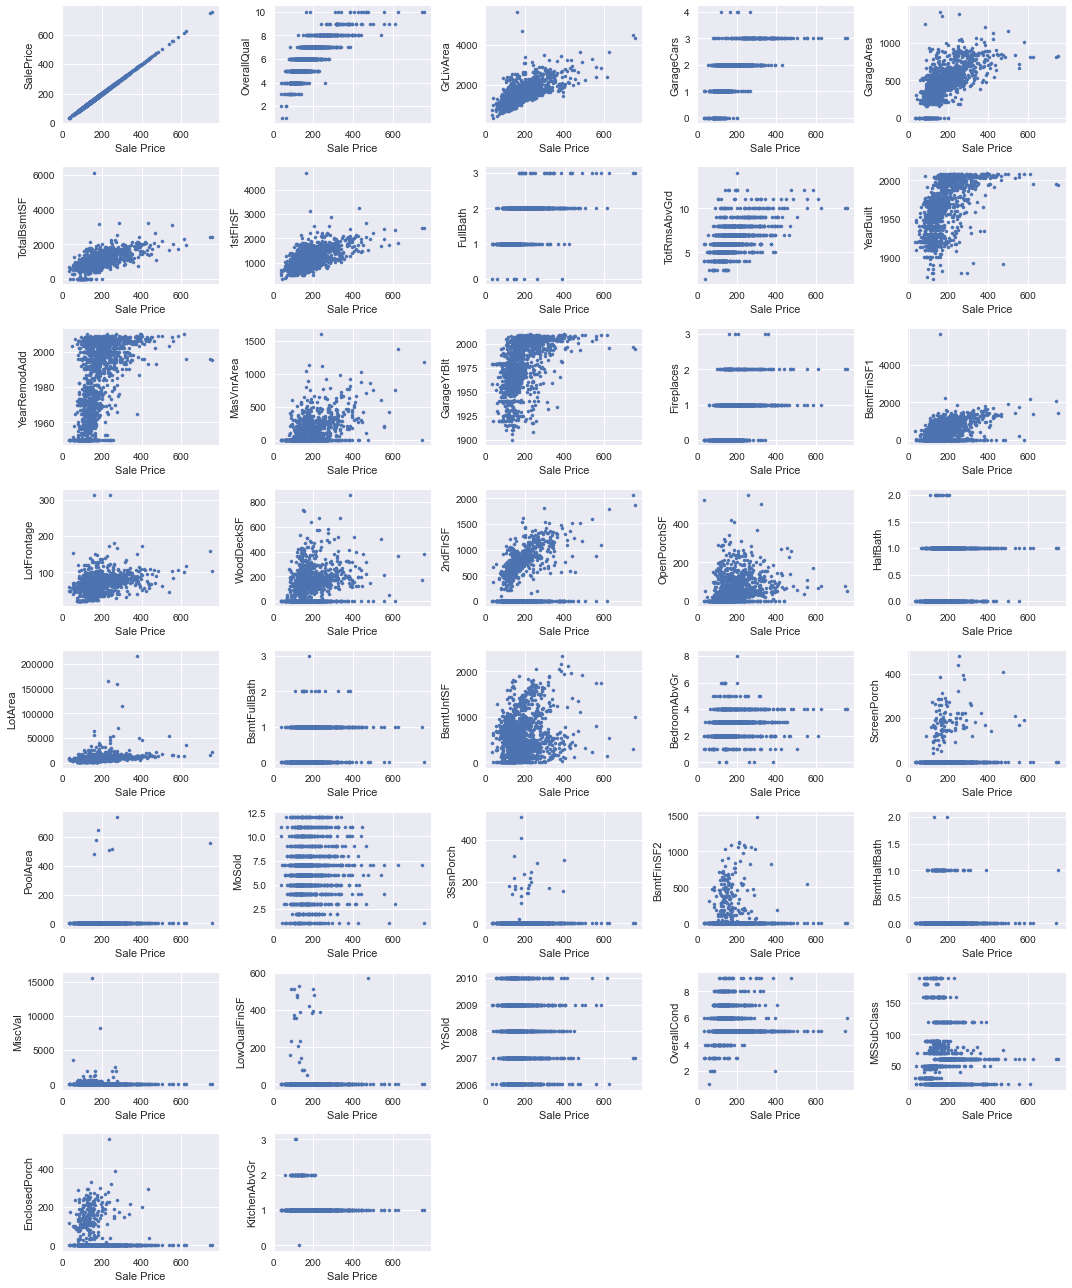

In [21]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_features_correlation.SalePrice.index:
    plt.subplot(8,5,i)
    plt.scatter(train.SalePrice, train[col], s=10)
    plt.xlabel('Sale Price')
    plt.ylabel(col)
    i +=1
    
plt.tight_layout()
plt.show()

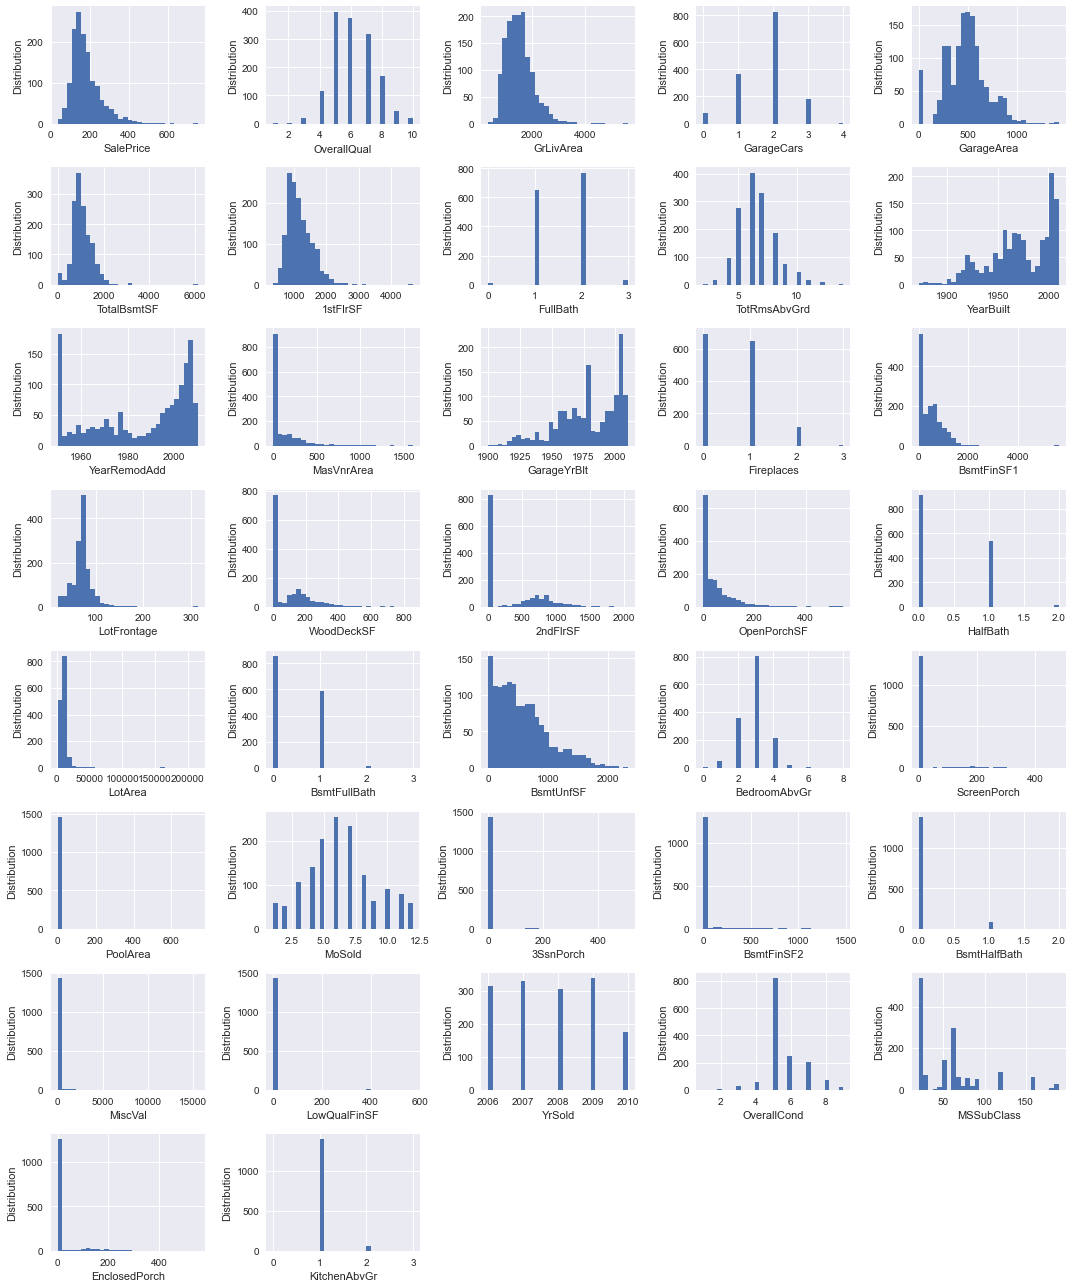

In [22]:
plt.figure(figsize=(15, 18))

i = 1
for col in numerical_features_correlation.SalePrice.index:
    plt.subplot(8,5,i)
    plt.hist(train[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('Distribution')
    i +=1
    
plt.tight_layout()
plt.show()

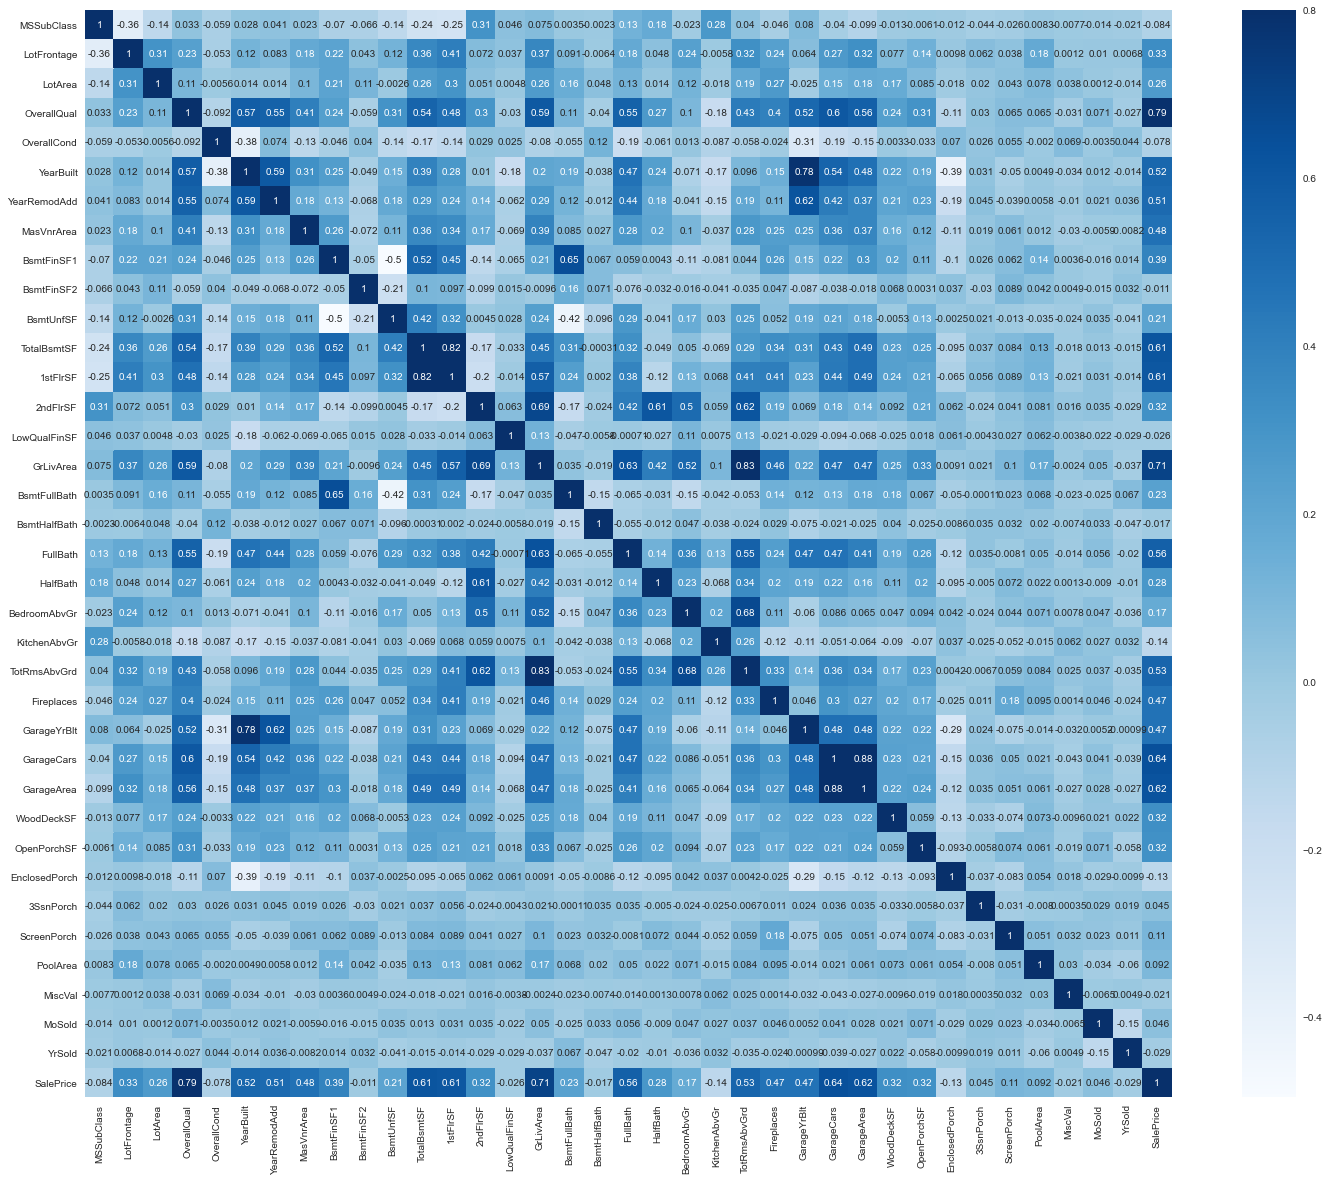

In [23]:
corr_mat = train.corr()
k = len(train.columns)
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values)
f, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(corr_mat, vmax=.8, square=True, annot = True, cmap = 'Blues')
plt.show()

#### Фючър селекшън на цифровите променливи

Променливи, които са с корелация м/у -0,05 и 0,05 и които на практика почи не оказват влияние върху стойността

In [24]:
low_price_corr_columns = corr_mat['SalePrice'][abs(corr_mat['SalePrice'].values) < 0.05].index.values
low_price_corr_columns

array(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch',
       'MiscVal', 'MoSold', 'YrSold'], dtype=object)

In [25]:
train = train.drop(list(low_price_corr_columns), axis=1)

Площта на гаража и броят коли, за които е предназначен са напрактика препокриващи се променливи, силно зависими една от друга. изчиствам площтта, която е смалко по-ниска корелация

In [26]:
train = train.drop('GarageArea', axis=1)

махам площ на втори етаж. имаме колони с цялата площ и с площта на първия етаж. втория е разлика от двете. има много нулеви стойности в него, заради етажността на сградите.

In [27]:
train = train.drop(['2ndFlrSF'], axis=1)

премахваме променливата за незавършен сутерен, тъй като имаме площ на целия и стойност на завършения сутерен

In [28]:
train = train.drop('BsmtUnfSF', axis=1)

In [29]:
train = train.drop('TotRmsAbvGrd', axis=1)

In [30]:
# Променливата PoolQC има 1453 липсващи стойности от общо 1460 записа, поради което приемаме, че тя не носи стойност към цената.
train = train.drop('PoolQC', axis=1)

#### Анализ на категорийните променливи

In [31]:
# Превръщам цифровите променливи, които по смисълът си трябва да са категорийни, също преобразувам в такива.
train.MSSubClass = train.MSSubClass.astype('object')

In [32]:
# презаписвам променливата след направената корекция
categorical_columns = train.select_dtypes(include=['object'])

In [33]:
categorical_description_df = categorical_columns.describe().T
categorical_description_df

,count,unique,top,freq
MSSubClass,1460,15,20,536
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,1460,3,Not avalable,1369
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225


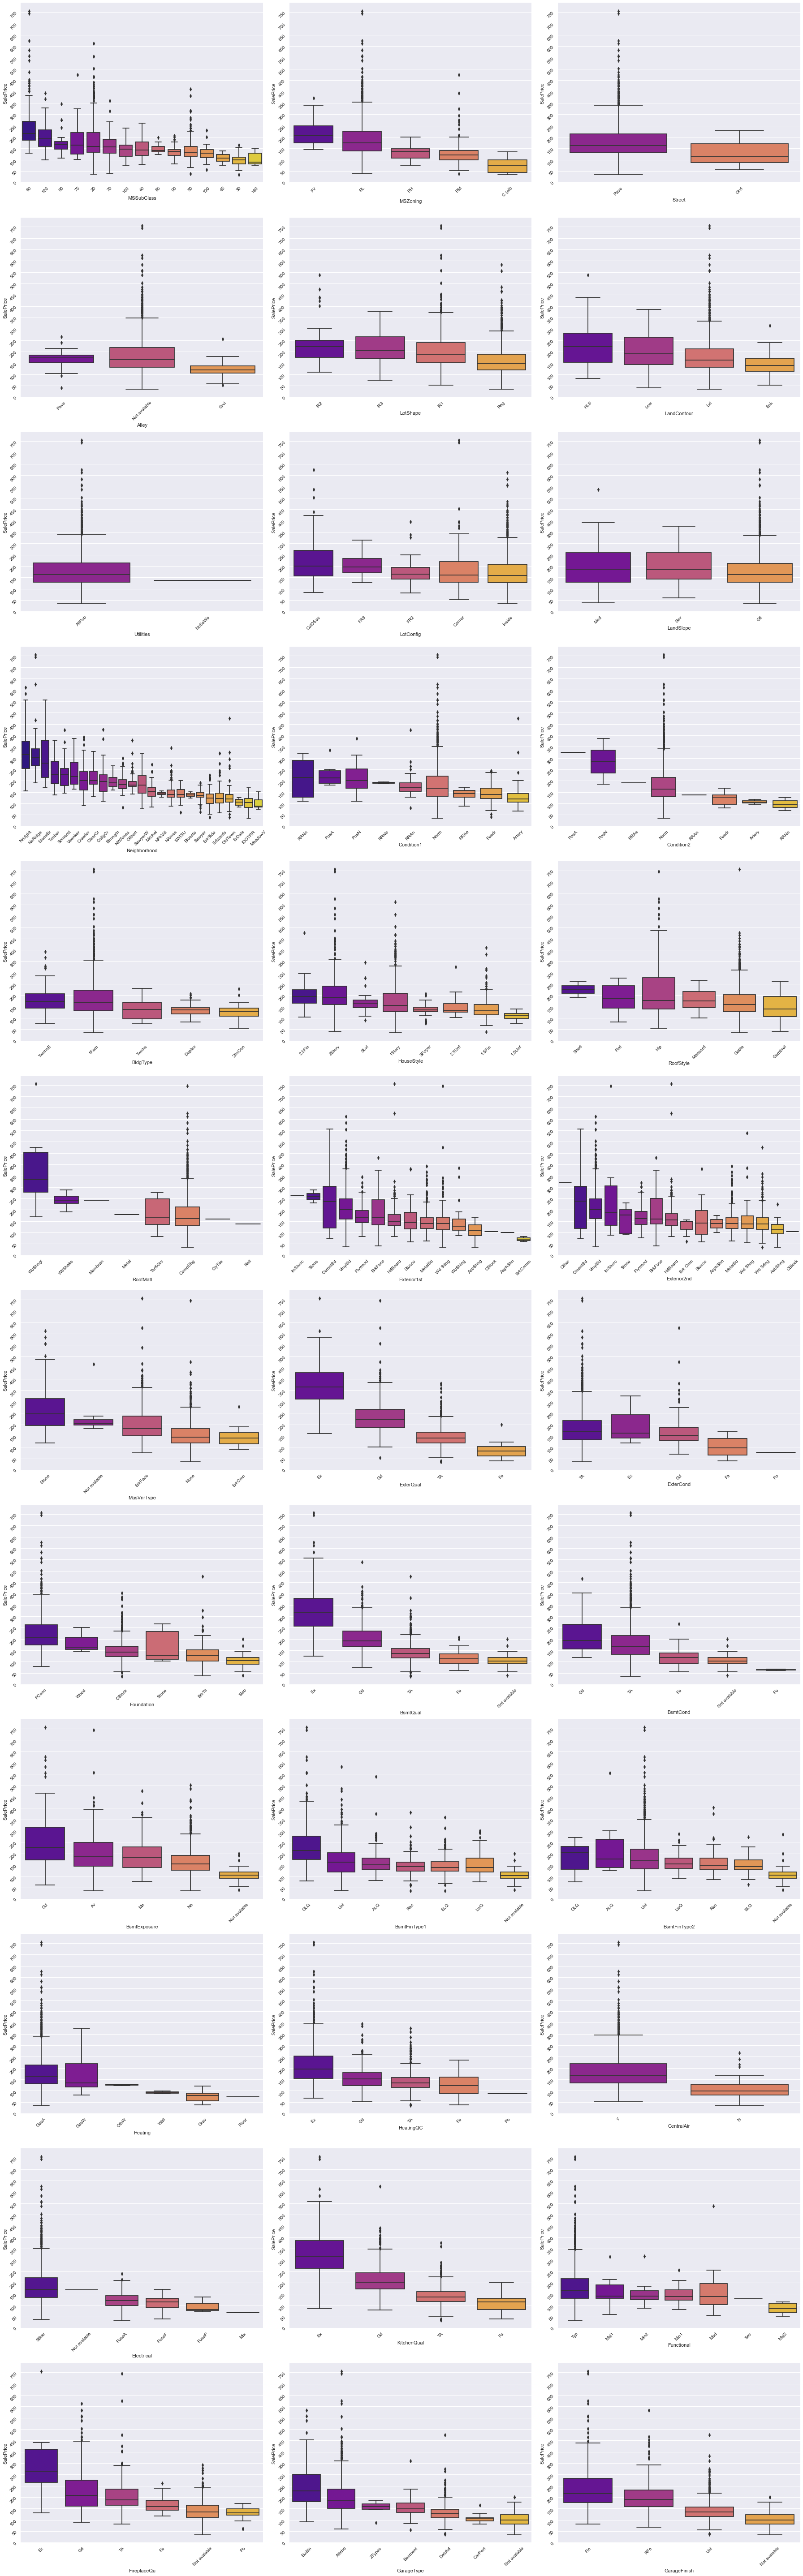

In [34]:
def srt_box(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(train[[col for col in train.select_dtypes(include=['object'])]], axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(ticker.MaxNLocator(nbins=18))

        plt.tight_layout()
     

srt_box('SalePrice', train)

От диаграмите може да се направи извод, че има голямо нетипични стойности при категорийните променливи. Прави впечатление, че те често принадлежат към един или два класа от съответната категория, най-често в посока нагоре, което може да означава, че категорията не едобре разделена на класове или че променливата е излишна като цяло, тъй като в една категория попадат почти всички записи и има нужда от задълбочен анализ, който да създаде подредени или неподредени стойности, които правилно да описват обектите на оценка.

#### Фючър селекшън на категорийни променливи

Всички променливи, които касаят оценка на състояние и качество, са силно натоварени със субективното мнение на даващия оценката. Това може да бъде както едно лице, така и различни лица. Променливите трябва да бъдат измерими и обективни. Преценям, че тези променливи и зададените в тях стойности в голяма степен може да обърква моделите и ги отстранявам. 

In [35]:
# train = train.drop(['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 
#                     'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond',
#                    'BsmtFinType1', 'BsmtFinType2', 'Condition2'], axis=1)
train = train.drop(['ExterQual', 'ExterCond', 'BsmtCond', 'HeatingQC', 
                    'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond',
                   'BsmtFinType1', 'BsmtFinType2'], axis=1)

In [36]:
categorical_description_df[categorical_description_df.freq > 1400]

,count,unique,top,freq
Street,1460,2,Pave,1454
Utilities,1460,2,AllPub,1459
Condition2,1460,8,Norm,1445
RoofMatl,1460,8,CompShg,1434
Heating,1460,6,GasA,1428
MiscFeature,1460,5,Not avalable,1406


In [37]:
train = train.drop(categorical_description_df[categorical_description_df.freq > 1400].index, axis=1)

#### Отстраняване на малък брой забележими аутлайъри в променливите с най-висока корелация със зависимата променлива.

In [38]:
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300) ].index)
train = train.drop(train[(train.GrLivArea > 500) & (train.SalePrice < 50)].index)
train = train.drop(train[(train.OverallCond < 3) & (train.SalePrice > 300)].index)

### 3. Анализ на зависимата променлива 

In [39]:
train.SalePrice.describe()

count    1454.000000
mean      181.081818
std        79.139377
min        35.311000
25%       130.000000
50%       163.000000
75%       214.000000
max       755.000000
Name: SalePrice, dtype: float64

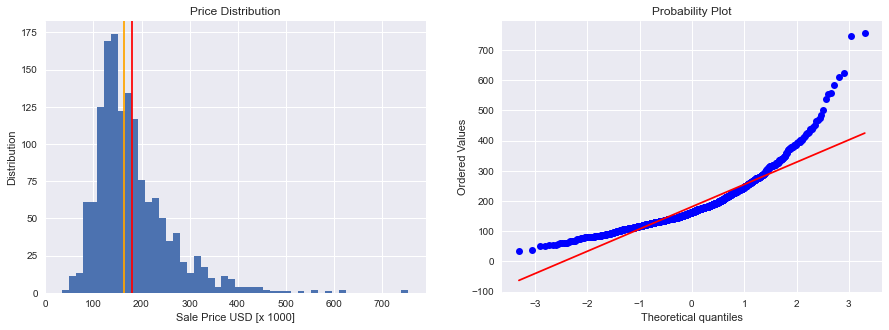

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(train.SalePrice, bins=50)
plt.axvline(train.SalePrice.mean(), color='red')
plt.axvline(train.SalePrice.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(train['SalePrice'], plot=plt)

plt.show()

От описанието и хистограмата на променливата "Цена", се вижда, че 75% от стойностите на имотите са под 214хил, което ще създаде проблем при предвижданията.
Ще приложим log transformation, така че грешките при прогнозиране на скъпи къщи и евтини къщи да повлияят еднакво на резултата. 

In [41]:
log_prices = np.log1p(train.SalePrice)

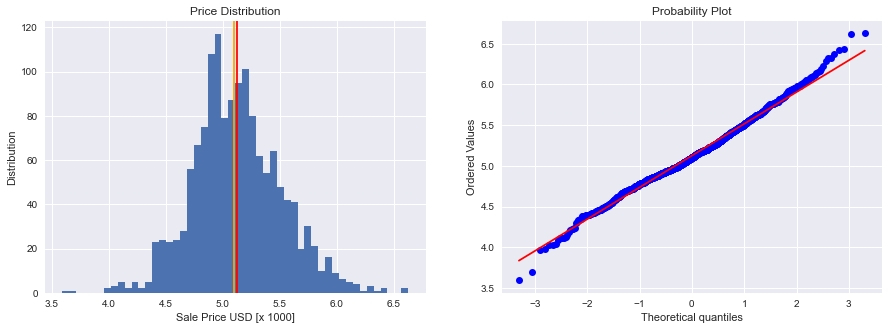

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.hist(log_prices, bins=50)
plt.axvline(log_prices.mean(), color='red')
plt.axvline(log_prices.median(), color='orange')
plt.title('Price Distribution')
plt.xlabel('Sale Price USD [х 1000]')
plt.ylabel('Distribution')

plt.subplot(1,2,2)
stats.probplot(log_prices, plot=plt)

plt.show()

От диаграмите в анализа на цифровите променливи се забелязва, че голяма част от тях са със сходно разпределение. Забелязва се характерната фуниевидна форма - хетероскедастик шейп. Наличието на хетероскедастичност е основен проблем при регресионния анализ и анализа на дисперсията, тъй като обезсилва статистическите тестове за значимост, които приемат, че всички грешки при моделирането имат една и съща вариация. Познати са редица методи за корекция на това явление, но за целите на настоящия проект, ще подходим по същия начин като при зависимата променлива и ще приложим логаритмична трансформация какт она на цената, така и на всички променливи, които са със скю > 0,5. Този филтър се налага, тъй като прилагането на трансформацията върху данни с по-малко изкривяване, може да доведе до обратния ефект.

In [43]:
skewness = train.select_dtypes(exclude='object').skew()
skewed_features = skewness[skewness>0.5]

train_log = train.copy()
for df in [train_log]:
    for col in skewed_features.index:
        df[col] = np.log1p(df[col])

### 3. Подготовка и разделяне на данните на сетове за трениране и тестване

In [44]:
train_log.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,Fence,SaleType,SaleCondition,SalePrice
0,60,RL,4.189655,9.042040,Not avalable,Reg,Lvl,Inside,Gtl,CollgCr,...,Y,0.000000,4.127134,0.000000,0.0,0.0,Not avalable,WD,Normal,5.344724
1,20,RL,4.394449,9.169623,Not avalable,Reg,Lvl,FR2,Gtl,Veenker,...,Y,5.700444,0.000000,0.000000,0.0,0.0,Not avalable,WD,Normal,5.206750
2,60,RL,4.234107,9.328212,Not avalable,IR1,Lvl,Inside,Gtl,CollgCr,...,Y,0.000000,3.761200,0.000000,0.0,0.0,Not avalable,WD,Normal,5.413876
3,70,RL,4.110874,9.164401,Not avalable,IR1,Lvl,Corner,Gtl,Crawfor,...,Y,0.000000,3.583519,5.609472,0.0,0.0,Not avalable,WD,Abnorml,4.948760
4,60,RL,4.442651,9.565284,Not avalable,IR1,Lvl,FR2,Gtl,NoRidge,...,Y,5.262690,4.442651,0.000000,0.0,0.0,Not avalable,WD,Normal,5.525453


In [45]:
train_log.shape

(1454, 52)

Разделям данните на фючърси и таргет

In [46]:
train_features = train_log.drop('SalePrice', axis=1)
train_target = train_log['SalePrice']

In [47]:
train_features.shape, train_target.shape

((1454, 51), (1454,))

Задавам бинарни стойности на категорийните променливи. Преценям, че скалиране на данните не е необходимо.

In [48]:
train_features= pd.get_dummies(train_features)

In [49]:
 train_features

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.189655,9.042040,7,1.791759,2003,2003,5.283204,6.561031,6.753438,6.753438,...,0,0,0,1,0,0,0,0,1,0
1,4.394449,9.169623,6,2.197225,1976,1976,0.000000,6.886532,7.141245,7.141245,...,0,0,0,1,0,0,0,0,1,0
2,4.234107,9.328212,7,1.791759,2001,2002,5.093750,6.188264,6.825460,6.825460,...,0,0,0,1,0,0,0,0,1,0
3,4.110874,9.164401,7,1.791759,1915,1970,0.000000,5.379897,6.629363,6.869014,...,0,0,0,1,1,0,0,0,0,0
4,4.442651,9.565284,8,1.791759,2000,2000,5.860786,6.486161,7.044033,7.044033,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.143135,8.976894,6,1.791759,1999,2000,0.000000,0.000000,6.860664,6.860664,...,0,0,0,1,0,0,0,0,1,0
1456,4.454347,9.486152,6,1.945910,1978,1988,4.787492,6.673298,7.341484,7.637234,...,0,0,0,1,0,0,0,0,1,0
1457,4.204693,9.109746,7,2.302585,1941,2006,0.000000,5.620401,7.050123,7.080868,...,0,0,0,1,0,0,0,0,1,0
1458,4.234107,9.181735,5,1.945910,1950,1996,0.000000,3.912023,6.983790,6.983790,...,0,0,0,1,0,0,0,0,1,0


In [50]:
train_features_set, test_features_set, train_target_set, test_target_set = train_test_split(
    train_features, train_target, train_size = 0.7, random_state=30)

In [51]:
train_features_set.shape, train_target_set.shape, 

((1017, 217), (1017,))

In [52]:
test_features_set.shape, test_target_set.shape

((437, 217), (437,))

In [53]:
k_fold = KFold(n_splits=5)
k_fold_train_splits = list(k_fold.split(train_features_set, train_target_set))

### 4. Създаване на модели и тяхното оценяване


* Линейната регресия е един от най -основните и популярни алгоритми в машинното обучение, тъй като е лесна и ясна за разбиране. В този проект ще я използваме за прогнозиране на цените на жилища, за да намерим възможно най -добрата линия, която следва тренировъчния ни сет, след което ще прогнозираме цена на имота от тестовия набор.
* Регресията на Lasso Lars е една от техникиje за намаляване на сложността на модела и предотвратяване прекалено следване на данните, резултат от проста линейна регресия. Параметрите на регуляризация могат да бъдат контролирани и по този начин да се постигне по-точна оценка на цените на жилищата. 
* Еластичната мрежа се появи за първи път в резултат на критика към ласото регресия, чийто избор на променлива може да бъде твърде зависим от данните и по този начин нестабилен. Решението е да комбинирате наказанията за регресия на хребета и ласо, за да извлечете най -доброто от двата свята. Еластичната мрежа основната цел е минимизиране на функцията за загуба.
* RANSAC
* Дърво на решенията
* Регресията за повишаване на градиента (GBR) е машинно обучение, което може да се използва за изграждане на прогнозен модел за регресионни проблеми като прогнозира цените на жилищата под формата на ансамбъл от слаби прогнози модели. GBR повтаря многократно моделите и засилва прогнозата на моделите със слаби прогнози и ги прави по -добъри. Основната цел е да намалим до минимум нашата Loss функция. 
* LinearSVR
* SVR 
* One class SVM
* KNeighborsRegressor

### Линейна регресия

In [54]:
params = {
    'normalize':[True, False],
    'fit_intercept': [True, False]
}
grid_search_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=params, cv=k_fold_train_splits)
grid_search_lin_reg.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_lin_reg.cv_results_).T

,0,1,2,3
mean_fit_time,0.0177886,0.0137398,0.0145203,0.0148578
std_fit_time,0.0020985,0.000338481,0.0012319,0.00116169
mean_score_time,0.00359678,0.00320687,0.00339017,0.00300016
std_score_time,0.000942699,0.000396971,0.000399197,0.000632485
param_fit_intercept,True,True,False,False
param_normalize,True,False,True,False
params,"{'fit_intercept': True, 'normalize': True}","{'fit_intercept': True, 'normalize': False}","{'fit_intercept': False, 'normalize': True}","{'fit_intercept': False, 'normalize': False}"
split0_test_score,-1.40134e+20,-7.3204e+17,0.857524,0.857524
split1_test_score,-5.2297e+18,-9.59126e+14,0.925222,0.925222
split2_test_score,-8.87185e+20,-3.02895e+16,0.913536,0.913536


In [55]:
evaluate(grid_search_lin_reg.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9447644685596164
Mean Absolute Error: 0.06413883313117127
Mean Squared Error: 0.008065387355795995
Root Mean Squared Error: 0.08980750166771145

**************************************************
TEST Sets results:

R2 Score: 0.9193881722234155
Mean Absolute Error: 0.07970495374744038
Mean Squared Error: 0.013617898513541442
Root Mean Squared Error: 0.11669575190871963


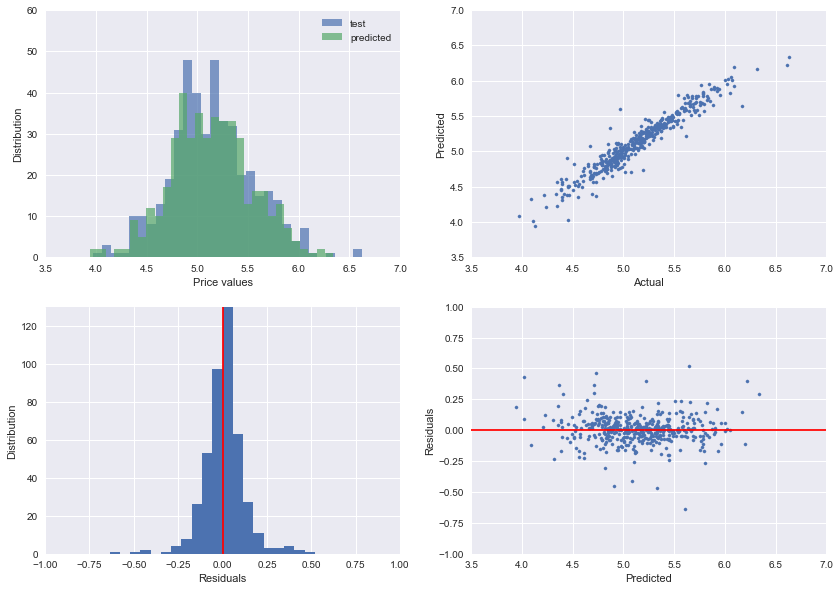

In [56]:
y_predict = grid_search_lin_reg.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predict)

### GRIDSearch с Lasso

In [57]:
params = {
    'alpha': [0.0003, 0.0004, 0.0005, 0.0006],
#     'fit_intercept': [True, False],
    'max_iter': [100000, 200000],
}
grid_search_lasso = GridSearchCV(estimator=Lasso(), param_grid=params, cv=k_fold_train_splits)
grid_search_lasso.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_lasso.cv_results_).T

,0,1,2,3,4,5,6,7
mean_fit_time,0.0178324,0.0162272,0.0130798,0.0187806,0.011421,0.012569,0.0120204,0.0122944
std_fit_time,0.00588051,0.00389178,0.00140185,0.00446476,0.00136582,0.00150826,0.00104548,0.00103939
mean_score_time,0.00277338,0.00313368,0.00301523,0.003754,0.00270166,0.00289965,0.00301981,0.00292187
std_score_time,0.000401021,0.000662403,2.85364e-05,0.00116336,0.000551925,0.000196822,3.83025e-05,0.000182527
param_alpha,0.0003,0.0003,0.0004,0.0004,0.0005,0.0005,0.0006,0.0006
param_max_iter,100000,200000,100000,200000,100000,200000,100000,200000
params,"{'alpha': 0.0003, 'max_iter': 100000}","{'alpha': 0.0003, 'max_iter': 200000}","{'alpha': 0.0004, 'max_iter': 100000}","{'alpha': 0.0004, 'max_iter': 200000}","{'alpha': 0.0005, 'max_iter': 100000}","{'alpha': 0.0005, 'max_iter': 200000}","{'alpha': 0.0006, 'max_iter': 100000}","{'alpha': 0.0006, 'max_iter': 200000}"
split0_test_score,0.891488,0.891488,0.891046,0.891046,0.890516,0.890516,0.890037,0.890037
split1_test_score,0.93711,0.93711,0.938431,0.938431,0.939178,0.939178,0.939167,0.939167
split2_test_score,0.925016,0.925016,0.924914,0.924914,0.923951,0.923951,0.923253,0.923253


In [58]:
evaluate(grid_search_lasso.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9368223616211017
Mean Absolute Error: 0.0684375962471049
Mean Squared Error: 0.009225078721297074
Root Mean Squared Error: 0.09604727336732195

**************************************************
TEST Sets results:

R2 Score: 0.9303458592486714
Mean Absolute Error: 0.07630980374322942
Mean Squared Error: 0.011766797081296914
Root Mean Squared Error: 0.10847486843180273


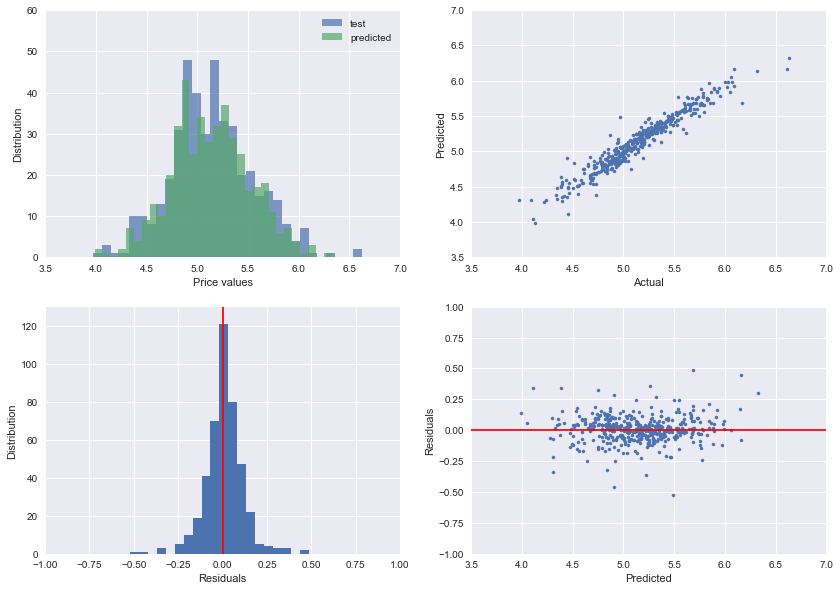

In [59]:
y_predicted_lasso = grid_search_lasso.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_lasso)

In [60]:
coef_df = pd.DataFrame(zip(test_features_set.columns.T, grid_search_lasso.best_estimator_.coef_ ), columns=['feature', 'coefficient'])

In [61]:
coef_df.shape

(217, 2)

In [62]:
coef_df[coef_df.coefficient > 0].sort_values('coefficient', ascending=False).head(10)

,feature,coefficient
10,GrLivArea,0.380133
3,OverallCond,0.281759
85,Neighborhood_StoneBr,0.120294
216,SaleCondition_Partial,0.100494
69,Neighborhood_Crawfor,0.097608
119,Exterior1st_BrkFace,0.088732
1,LotArea,0.085490
9,1stFlrSF,0.081351
79,Neighborhood_NridgHt,0.073679
182,Functional_Typ,0.073571


### Elastic Net

In [63]:
params = {
#     'alpha': [0.0005, 0.0007, 0.0008, 0.001, 0.002],
    'alpha': [0.0001, 0.0002, 0.0003, 0.0004],
#     'l1_ratio': [0.3, 0.5, 0.6, 0.7, 0.8, 0.9],
    'l1_ratio': [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
#     'fit_intercept': [True, False],
    'max_iter': [100000, 200000],
}
grid_search_elastic = GridSearchCV(estimator=ElasticNet(), param_grid=params, cv=k_fold_train_splits)
grid_search_elastic.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_elastic.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
mean_fit_time,0.0443592,0.0427196,0.0399858,0.0376692,0.0382566,0.0422802,0.0397357,0.040159,0.0408263,0.0448224,...,0.0200938,0.0222955,0.0205751,0.0210958,0.0207034,0.0237581,0.0154448,0.0140268,0.0140471,0.013602
std_fit_time,0.00966524,0.00703065,0.0141732,0.0114768,0.0154837,0.0136519,0.0244499,0.0226049,0.029376,0.0281876,...,0.00208411,0.00281238,0.00259947,0.00277484,0.00339069,0.0103899,0.00182192,0.00170585,0.00226151,0.00205681
mean_score_time,0.00369425,0.00379925,0.00341601,0.0041975,0.00357275,0.00350809,0.0032567,0.00340543,0.00340147,0.00423017,...,0.00339975,0.00334315,0.00340791,0.00303745,0.00423884,0.00382996,0.00320749,0.00295043,0.00320544,0.00308509
std_score_time,0.000402853,0.000399737,0.000510107,0.000980638,0.000471761,0.000993876,0.000821565,0.000485898,0.000488858,0.0014427,...,0.000489473,0.000949886,0.000487299,5.77961e-05,0.00119805,0.000989462,0.00097835,0.000206922,0.000387178,0.000535324
param_alpha,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,...,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004,0.0004
param_l1_ratio,0.3,0.3,0.5,0.5,0.6,0.6,0.7,0.7,0.8,0.8,...,0.6,0.6,0.7,0.7,0.8,0.8,0.9,0.9,1,1
param_max_iter,100000,200000,100000,200000,100000,200000,100000,200000,100000,200000,...,100000,200000,100000,200000,100000,200000,100000,200000,100000,200000
params,"{'alpha': 0.0001, 'l1_ratio': 0.3, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.3, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.5, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.5, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.6, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.6, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.7, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.7, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.8, 'max_iter':...","{'alpha': 0.0001, 'l1_ratio': 0.8, 'max_iter':...",...,"{'alpha': 0.0004, 'l1_ratio': 0.6, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.6, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.7, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.7, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.8, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.8, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.9, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 0.9, 'max_iter':...","{'alpha': 0.0004, 'l1_ratio': 1, 'max_iter': 1...","{'alpha': 0.0004, 'l1_ratio': 1, 'max_iter': 2..."
split0_test_score,0.873776,0.873776,0.877458,0.877458,0.879055,0.879055,0.880495,0.880495,0.881828,0.881828,...,0.891219,0.891219,0.891311,0.891311,0.891311,0.891311,0.891203,0.891203,0.891046,0.891046
split1_test_score,0.930461,0.930461,0.931726,0.931726,0.93211,0.93211,0.932503,0.932503,0.932824,0.932824,...,0.936491,0.936491,0.93701,0.93701,0.937532,0.937532,0.938071,0.938071,0.938431,0.938431


In [64]:
evaluate(grid_search_elastic.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9374108916859281
Mean Absolute Error: 0.06810079340710748
Mean Squared Error: 0.009139142679412869
Root Mean Squared Error: 0.09559886337929374

**************************************************
TEST Sets results:

R2 Score: 0.9300149417401709
Mean Absolute Error: 0.07636930707552511
Mean Squared Error: 0.01182269956076437
Root Mean Squared Error: 0.10873223790929887


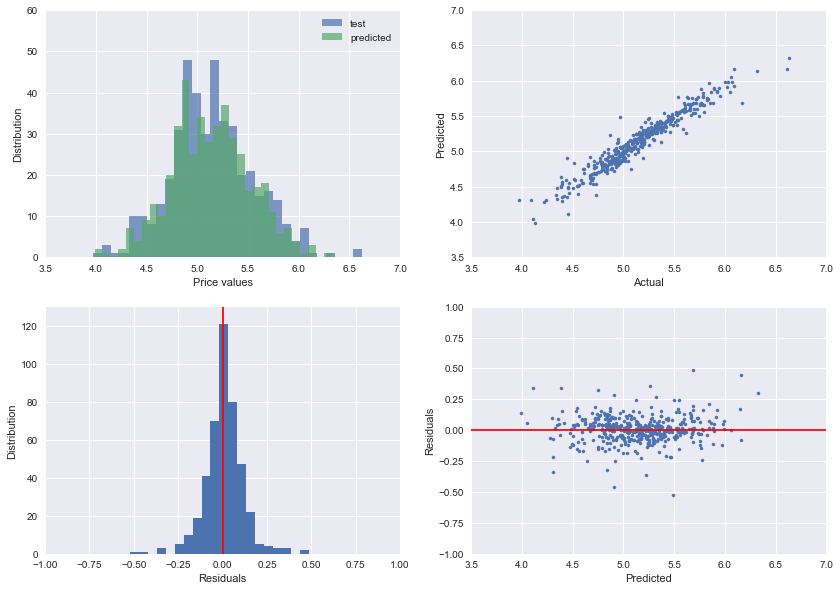

In [65]:
y_predicted_elastic = grid_search_lasso.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_elastic)

### RANSAC

In [66]:
params = {
#     'min_samples': [300, 400, 450, 500]
    'min_samples': [0.9, 0.95, 0.99],
}

grid_search_ransac = GridSearchCV(estimator=RANSACRegressor(base_estimator=grid_search_lasso.best_estimator_, random_state=1), 
                                  param_grid=params, 
                                  cv=k_fold_train_splits)
grid_search_ransac.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_ransac.cv_results_).T

,0,1,2
mean_fit_time,1.1719,1.18331,1.19499
std_fit_time,0.1709,0.146855,0.209897
mean_score_time,0.00340428,0.00294552,0.00350437
std_score_time,0.000494829,0.000531071,0.00101633
param_min_samples,0.9,0.95,0.99
params,{'min_samples': 0.9},{'min_samples': 0.95},{'min_samples': 0.99}
split0_test_score,0.890824,0.891226,0.890897
split1_test_score,0.939726,0.940336,0.939171
split2_test_score,0.92545,0.92615,0.927037
split3_test_score,0.90603,0.907131,0.906953


In [67]:
evaluate(grid_search_ransac.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9322671437854508
Mean Absolute Error: 0.06798560712217364
Mean Squared Error: 0.00989022297494126
Root Mean Squared Error: 0.09944960017486879

**************************************************
TEST Sets results:

R2 Score: 0.9325654968134209
Mean Absolute Error: 0.0748413458512072
Mean Squared Error: 0.011391829785215041
Root Mean Squared Error: 0.10673251512643671


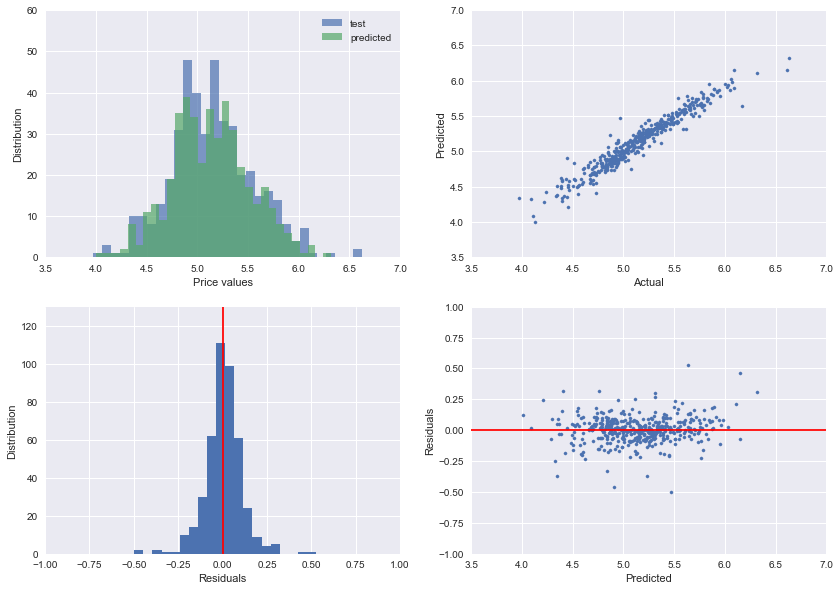

In [68]:
y_predicted_ransac = grid_search_ransac.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_ransac)

In [69]:
inliers = train_features_set[grid_search_ransac.best_estimator_.inlier_mask_]
outliers = train_features_set[~grid_search_ransac.best_estimator_.inlier_mask_]
len(inliers), len(outliers)

(995, 22)

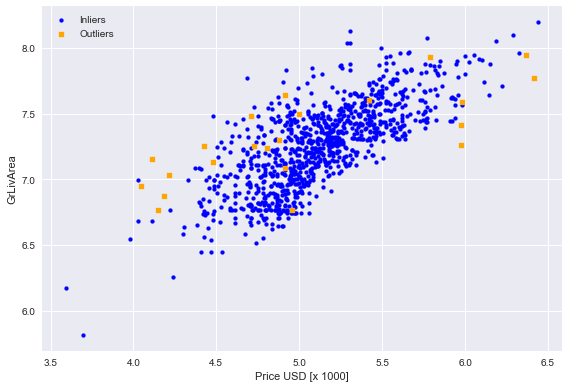

In [70]:
plt.scatter(
    train_target_set[inliers.index], 
    train_features_set.GrLivArea[inliers.index], 
    c='blue', 
    marker='o', 
    s= 15, 
    label='Inliers'
)
plt.scatter(
    train_target_set[outliers.index], 
    train_features_set.GrLivArea[outliers.index], 
    c='orange', 
    marker='s', 
    s=25, 
    label='Outliers'
)

plt.xlabel('Price USD [x 1000]')
plt.ylabel('GrLivArea')
plt.legend(loc='upper left')
 
plt.tight_layout()
plt.show()

### Grid Search Decision Tree

In [71]:
params = {
    'max_depth': [5, 6, 7, 8, 9, 10, 11],
    'max_leaf_nodes': [30,40, 50, 60, 70, 80],
    'min_samples_leaf': [2,3, 4, 5, 7, 10],
    'max_features': [50,70,80,100]
    
}
grid_search_DTR = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params, cv=k_fold_train_splits)
grid_search_DTR.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_DTR.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,998,999,1000,1001,1002,1003,1004,1005,1006,1007
mean_fit_time,0.00699182,0.00577588,0.00498219,0.00522203,0.00620809,0.00699949,0.00563278,0.00679584,0.00678234,0.00514941,...,0.00947518,0.00900297,0.00929251,0.0104506,0.0125813,0.0130444,0.011458,0.00874405,0.0117443,0.00759859
std_fit_time,0.00155163,0.000699376,3.23721e-05,0.000424707,0.00194258,0.00352086,0.000515859,0.00276119,0.00145127,0.000435317,...,0.00184027,0.00209434,0.00196664,0.00303704,0.00274177,0.00395888,0.00377197,0.000454856,0.00389384,0.000489849
mean_score_time,0.00282598,0.00242329,0.00219975,0.00236535,0.00259242,0.00261798,0.00239806,0.00281892,0.00280089,0.00220137,...,0.00339265,0.0025969,0.00306711,0.00280023,0.0034008,0.00373836,0.00358047,0.00222397,0.00279756,0.00240126
std_score_time,0.000786143,0.000485101,0.000437379,0.000485878,0.00119745,0.00083126,0.000487604,0.0011488,0.00160006,0.000401712,...,0.00150398,0.000487235,0.00145903,0.00160003,0.00149662,0.00151094,0.00120054,0.000426717,0.000391099,0.000492399
param_max_depth,5,5,5,5,5,5,5,5,5,5,...,11,11,11,11,11,11,11,11,11,11
param_max_features,50,50,50,50,50,50,50,50,50,50,...,100,100,100,100,100,100,100,100,100,100
param_max_leaf_nodes,30,30,30,30,30,30,40,40,40,40,...,70,70,70,70,80,80,80,80,80,80
param_min_samples_leaf,2,3,4,5,7,10,2,3,4,5,...,4,5,7,10,2,3,4,5,7,10
params,"{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...","{'max_depth': 5, 'max_features': 50, 'max_leaf...",...,"{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le...","{'max_depth': 11, 'max_features': 100, 'max_le..."
split0_test_score,0.71245,0.595716,0.595594,0.682233,0.643029,0.61486,0.642753,0.665587,0.635446,0.666388,...,0.702438,0.686693,0.714422,0.69282,0.660753,0.71419,0.725858,0.697504,0.713263,0.676784


In [72]:
evaluate(grid_search_DTR.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.8599835151227971
Mean Absolute Error: 0.10592530234546049
Mean Squared Error: 0.020444941096483267
Root Mean Squared Error: 0.14298580732535404

**************************************************
TEST Sets results:

R2 Score: 0.7499069861533197
Mean Absolute Error: 0.15451205092067213
Mean Squared Error: 0.04224865476253448
Root Mean Squared Error: 0.20554477556613907


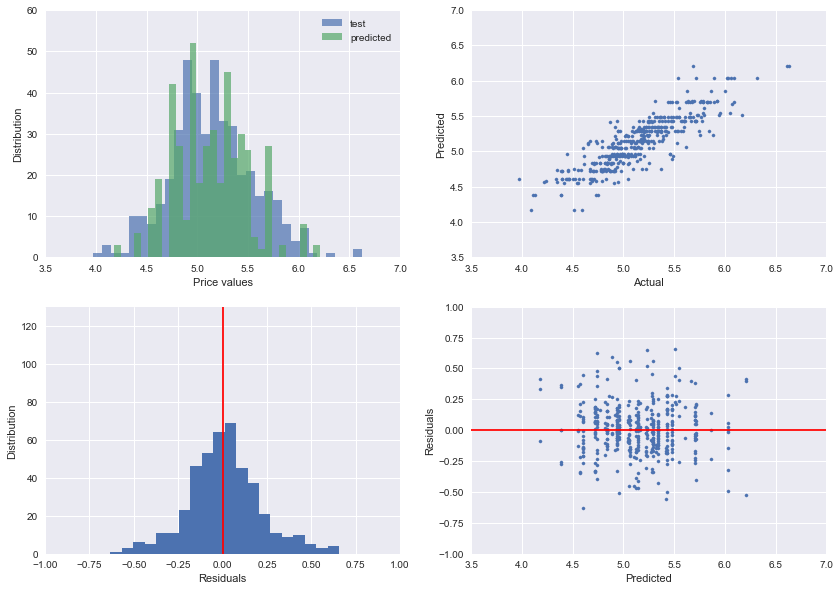

In [73]:
y_predicted_grid_dtr = grid_search_DTR.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_grid_dtr)

In [74]:
feature_importance_grid_DT = pd.DataFrame(zip(train_features_set.columns, grid_search_DTR.best_estimator_.feature_importances_), columns=['feature', 'value'])

In [75]:
feature_importance_grid_DT.sort_values(by='value', ascending=False).head(10)

,feature,value
12,FullBath,0.412369
8,TotalBsmtSF,0.169533
9,1stFlrSF,0.082214
10,GrLivArea,0.080907
13,HalfBath,0.059508
2,OverallQual,0.047952
169,CentralAir_Y,0.032399
17,GarageYrBlt,0.024425
0,LotFrontage,0.011057
4,YearBuilt,0.010450


### GBR - Gradient Boosting Regressor

In [76]:
params = {
    'loss': ['ls', 'lad', 'huber'],
    'n_estimators': [200, 250, 300, 350, 400],
    'criterion': ['mse'],
    'subsample': [0.3, 0.4, 0.5, 0.6, 0.7]
}
grid_search_gbr = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=params, cv=k_fold_train_splits)
grid_search_gbr.fit(train_features_set, train_target_set)
pd.DataFrame(grid_search_gbr.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
mean_fit_time,0.357676,0.417947,0.546333,0.581066,0.678584,0.418441,0.543233,0.625999,0.720593,0.841872,...,1.05888,1.22913,1.35633,1.53271,1.66351,1.19231,1.35933,1.56128,1.72966,1.90559
std_fit_time,0.0143472,0.0179953,0.0390868,0.0213956,0.0155644,0.0191351,0.0264483,0.00421261,0.021112,0.0120119,...,0.00925942,0.0395143,0.0176323,0.0302095,0.0375651,0.0397416,0.0384669,0.0439587,0.0670851,0.0485323
mean_score_time,0.00368204,0.00407758,0.00399847,0.00376873,0.00637546,0.00381808,0.00417914,0.00401406,0.00441151,0.00300035,...,0.00623083,0.00380979,0.00442867,0.00562024,0.00380411,0.0046134,0.00560288,0.00584259,0.00502582,0.00479689
std_score_time,0.000613053,0.000905494,0.00252887,0.000413508,0.00230465,0.0016446,0.00195994,0.00157846,0.00176023,2.4314e-07,...,0.00251705,0.000749607,0.00134843,0.00285028,0.000402526,0.00119342,0.0020222,0.00206804,0.00158909,0.00213841
param_criterion,mse,mse,mse,mse,mse,mse,mse,mse,mse,mse,...,mse,mse,mse,mse,mse,mse,mse,mse,mse,mse
param_loss,ls,ls,ls,ls,ls,ls,ls,ls,ls,ls,...,huber,huber,huber,huber,huber,huber,huber,huber,huber,huber
param_n_estimators,200,200,200,200,200,250,250,250,250,250,...,350,350,350,350,350,400,400,400,400,400
param_subsample,0.3,0.4,0.5,0.6,0.7,0.3,0.4,0.5,0.6,0.7,...,0.3,0.4,0.5,0.6,0.7,0.3,0.4,0.5,0.6,0.7
params,"{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...","{'criterion': 'mse', 'loss': 'ls', 'n_estimato...",...,"{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim...","{'criterion': 'mse', 'loss': 'huber', 'n_estim..."
split0_test_score,0.858281,0.873382,0.879542,0.887295,0.871199,0.878885,0.873813,0.877499,0.880465,0.864976,...,0.885024,0.887142,0.890691,0.888386,0.878581,0.884629,0.883299,0.892268,0.88474,0.880028


In [77]:
evaluate(grid_search_gbr.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

TRAIN Sets results:

R2 Score: 0.9792296114221171
Mean Absolute Error: 0.03324880125533193
Mean Squared Error: 0.003032852677299477
Root Mean Squared Error: 0.055071341706004195

**************************************************
TEST Sets results:

R2 Score: 0.9245798510387405
Mean Absolute Error: 0.08095160665082886
Mean Squared Error: 0.012740859037176465
Root Mean Squared Error: 0.11287541378518381


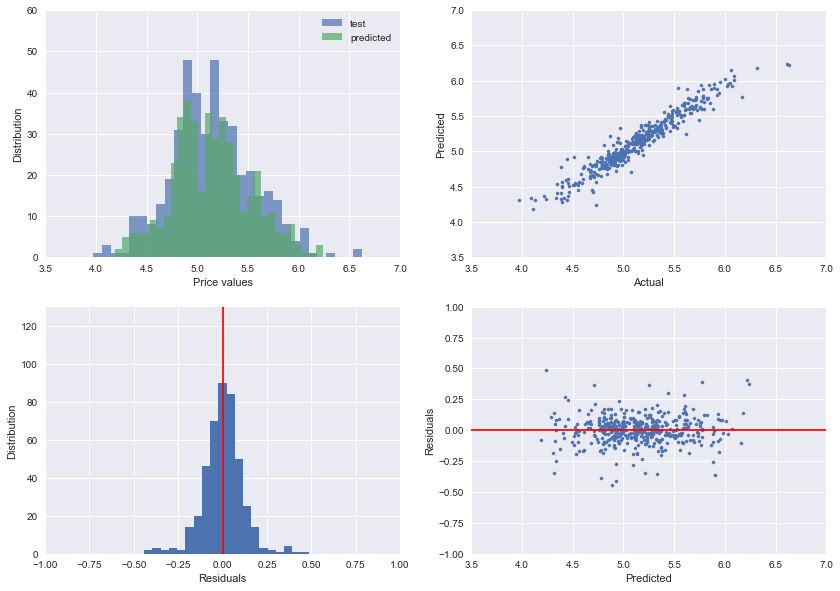

In [78]:
y_predicted_gbr = grid_search_gbr.best_estimator_.predict(test_features_set)
plot(test_target_set, y_predicted_gbr)

In [79]:
feature_importance_grid_gbr = pd.DataFrame(zip(train_features_set.columns, grid_search_gbr.best_estimator_.feature_importances_), columns=['feature', 'value'])

In [80]:
feature_importance_grid_gbr.sort_values(by='value', ascending=False).head(10)

,feature,value
2,OverallQual,0.417741
10,GrLivArea,0.156767
4,YearBuilt,0.076219
8,TotalBsmtSF,0.054045
7,BsmtFinSF1,0.035594
1,LotArea,0.030080
18,GarageCars,0.026015
5,YearRemodAdd,0.020757
12,FullBath,0.017576
9,1stFlrSF,0.015302


### Linear SVR

In [81]:
# params = {
#     'C': [0.001, 0.002],
#     'max_iter': [1e6]
# }
# grid_search_linear_svr = GridSearchCV(estimator=LinearSVR(), param_grid=params, cv=k_fold_train_splits)
# grid_search_linear_svr.fit(train_features_set, train_target_set)

In [82]:
# evaluate(grid_search_linear_svr.best_estimator_, train_features_set, train_target_set, test_features_set, test_target_set)

In [83]:
# y_predicted_linnear_svr = grid_search_linear_svr.best_estimator_.predict(test_features_set)

In [84]:
# plot(test_target_set, y_predicted_linnear_svr)

### OneClassSVM

In [85]:
one_class_svm = OneClassSVM(kernel='poly', degree=2, gamma='scale', nu=0.02)
one_class_svm.fit(train_features_set, train_target_set)

OneClassSVM(degree=2, kernel='poly', nu=0.02)

In [86]:
predictions_train = one_class_svm.predict(train_features_set)
predictions_train.sum() / len(predictions_train)

0.960668633235005

In [87]:
predictions_train.sum(), len(predictions_train)

(977, 1017)

In [88]:
ocsvm_df_train = pd.DataFrame(predictions_train)

In [89]:
pred_1 = ocsvm_df_train[predictions_train == 1]

In [90]:
pred_2 = ocsvm_df_train[predictions_train == -1]

In [91]:
outliers_df_train = train_features_set.iloc[pred_2.index]

In [92]:
(predictions_train == 1).sum(), (predictions_train == - 1).sum()

(997, 20)

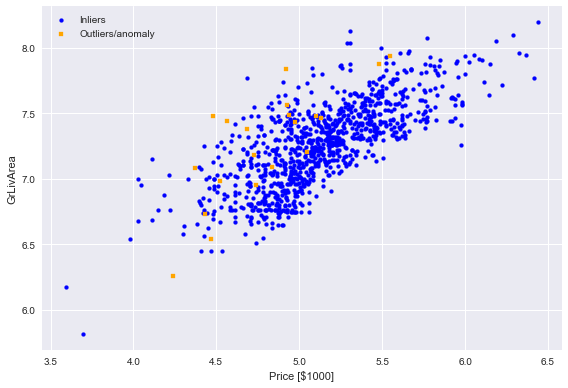

In [93]:
plt.scatter(train_target_set.iloc[pred_1.index], train_features_set.GrLivArea.iloc[pred_1.index], c='blue', marker='o', s= 15, label='Inliers')
plt.scatter(train_target_set.iloc[pred_2.index], train_features_set.GrLivArea.iloc[pred_2.index], c='orange', marker='s', s=20, label='Outliers/anomaly')

plt.xlabel('Price [$1000]')
plt.ylabel('GrLivArea')
plt.legend(loc='upper left')
 
plt.tight_layout()
plt.show()

In [94]:
predictions_test = one_class_svm.predict(test_features_set)

In [95]:
predictions_test.sum() / len(predictions_test)

0.9359267734553776

In [96]:
lasso_reg_without_outliers = Lasso(alpha=0.0003)
lasso_reg_without_outliers.fit(train_features_set.iloc[pred_1.index], train_target_set.iloc[pred_1.index])

Lasso(alpha=0.0003)

In [97]:
lasso_reg_without_outliers.score(train_features_set.iloc[pred_1.index], train_target_set.iloc[pred_1.index])

0.9380802718716307

In [98]:
lasso_reg_without_outliers.score(test_features_set, test_target_set)

0.9295667979226699

In [99]:
y_predicted_OCSVM_without_outliers = lasso_reg_without_outliers.predict(test_features_set)

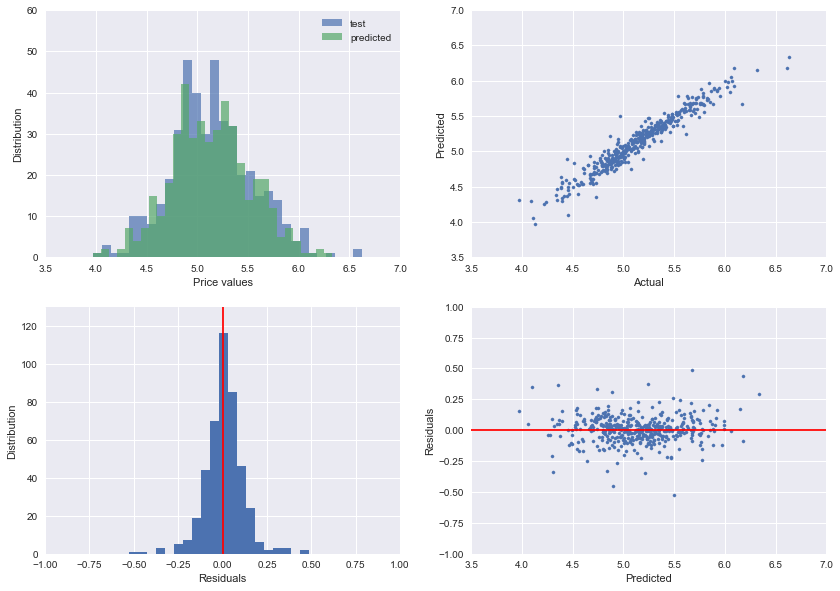

In [100]:
plot(test_target_set, y_predicted_OCSVM_without_outliers)

### KNeighborsRegressor

### 5. Резултати

In [141]:
all_models_dict = {
    'Linear Regression': grid_search_lin_reg.best_estimator_, 
    'Lasso': grid_search_lasso.best_estimator_, 
    'RANSAC Regressor': grid_search_ransac.best_estimator_,
    'Decision Tree Regressor': grid_search_DTR.best_estimator_, 
    'Gradient Boosting Regressor': grid_search_gbr.best_estimator_,
    'One Class SVM - wthout outl': lasso_reg_without_outliers
             }

In [142]:
# def final_evaluation(model, X_train, y_train, X_test, y_test):
#     pred_train = model.predict(X_train)
#     pred_test = model.predict(X_test)
#     r2_train = r2_score(y_train, pred_train) 
#     r2_test = r2_score(y_test, pred_test)
#     mae = mean_absolute_error(np.expm1(y_test), np.expm1(pred_test))
#     mse = mean_squared_error(np.expm1(y_test), np.expm1(pred_test))
#     rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(pred_test)))
#     return r2_train, r2_test, mae, mse, rmse
    

In [171]:
results_df = pd.DataFrame(columns=['Model','R2 - train', 'R2 - test','MAE - test', 'MSE - test', 'RMSE - test'])
for name, model in all_models_dict.items():
    result = pd.DataFrame(
        data=[[name, *final_evaluation(model, train_features_set, train_target_set, test_features_set, test_target_set)]], 
        columns=['Model', 'R2 - train', 'R2 - test','MAE - test', 'MSE - test', 'RMSE - test']
    )
    results_df = results_df.append(result, ignore_index=True) 
    
results_df

,Model,R2 - train,R2 - test,MAE - test,MSE - test,RMSE - test
0,Linear Regression,0.944764,0.919388,15.040494,737.190886,27.151259
1,Lasso,0.936822,0.930346,14.609401,719.206514,26.818026
2,RANSAC Regressor,0.932267,0.932565,14.442190,724.597604,26.918351
3,Decision Tree Regressor,0.859984,0.749907,29.682301,2106.713415,45.898948
4,Gradient Boosting Regressor,0.979230,0.924580,15.633735,748.227822,27.353753
5,One Class SVM - wthout outl,0.938088,0.929567,14.568699,710.905194,26.662805


In [172]:
# best_model = results_df[results_df['R2 - test'] == results_df['R2 - test'].max()]['Model']

In [173]:
best_model = results_df.Model[results_df['R2 - test'] == results_df['R2 - test'].max()].values

In [174]:
best_model

array(['RANSAC Regressor'], dtype=object)

In [183]:
best_prediction = all_models_dict[best_model[0]].predict(test_features_set)

In [175]:
# mutual_plot([v for _,v in all_models_dict.items()], test_features_set, test_target_set)

### Анализ

In [249]:
# Извеждаме моделът с най-добър резултат и неговите прогнози
best_model = results_df.Model[results_df['R2 - test'] == results_df['R2 - test'].max()].values
best_prediction = all_models_dict[best_model[0]].predict(test_features_set)

# Създаваме таблица с резултатите на най-добрия модел
test_prices = np.expm1(test_target_set)
predicted_prices = np.expm1(best_prediction)
residuals = test_prices - predicted_prices
predicted_prices_df = pd.DataFrame({'index': test_target_set.index,
                                    'test_price': list(test_prices), 
                                    'predicted_price': list(predicted_prices), 
                                    'residuals': list(residuals), 
                                    '%': list((abs(residuals)/test_prices)*100)})
predicted_prices_df.head()

,index,test_price,predicted_price,residuals,%
0,1003,136.905,154.296692,-17.391692,12.703475
1,221,200.000,203.914937,-3.914937,1.957468
2,1161,224.000,217.155848,6.844152,3.055425
3,835,128.000,129.608550,-1.608550,1.256679
4,1296,155.000,150.293681,4.706319,3.036335


In [250]:
predicted_prices_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,437.0,732.814645,408.560996,0.000000,389.000000,745.000000,1071.000000,1456.000000
test_price,437.0,186.267568,86.873863,52.000000,130.500000,167.900000,217.500000,755.000000
predicted_price,437.0,182.610136,74.446270,53.965760,129.608550,169.199509,217.770202,554.162726
residuals,437.0,3.657431,26.699289,-92.820217,-7.516657,1.367520,10.140570,276.820153
%,437.0,7.548806,7.953702,0.037808,2.261670,5.678868,9.645609,64.909243


In [257]:
predicted_prices_df[predicted_prices_df['%'] > 10]

,index,test_price,predicted_price,residuals,%
0,1003,136.905,154.296692,-17.391692,12.703475
11,56,172.500,196.011980,-23.511980,13.630134
14,1037,287.000,250.067704,36.932296,12.868396
19,738,179.000,140.371926,38.628074,21.579930
20,512,129.900,112.931439,16.968561,13.062788
...,...,...,...,...,...
425,1122,112.000,81.002520,30.997480,27.676321
426,1423,274.970,202.437099,72.532901,26.378478
429,671,103.600,117.614364,-14.014364,13.527378
430,807,223.500,198.745232,24.754768,11.075959


### 6. Референции